**IMPORTANTE: caso já tenha baixado a pasta colmap_project, inicie pela etapa 5.1 para as visualizações**

In [1]:
import pycolmap
from pathlib import Path
import shutil
import urllib.request
import zipfile
import io
import matplotlib.pyplot as plt
from PIL import Image

### Passo 1: Download e Preparação do Conjunto de Dados

Para este exemplo, usaremos o conjunto de dados "fox" do site oficial do COLMAP. O código abaixo irá baixá-lo e extraí-lo para a nossa pasta de imagens.

**IMPORTANTE: rodar a célula abaixo somente se for testar o código com o database de exemplo.**

In [17]:
# Limpa execuções anteriores para garantir um começo limpo
if Path('colmap_project').exists():
    shutil.rmtree('colmap_project')

# Define os diretórios para o nosso projeto
project_path = Path('colmap_project')
image_path = project_path / 'images'
database_path = project_path / 'database.db'
output_path = project_path / 'sparse'

# Cria os diretórios necessários
project_path.mkdir(exist_ok=True)
image_path.mkdir(exist_ok=True)
output_path.mkdir(exist_ok=True)

print(f"Diretórios do projeto criados em: {project_path.resolve()}")

# URL do dataset "fox"
dataset_url = "https://github.com/colmap/colmap/raw/dev/data/datasets/fox.zip"

print("Baixando o conjunto de dados 'fox'...")
with urllib.request.urlopen(dataset_url) as response:
    data = response.read()

print("Extraindo imagens...")
with zipfile.ZipFile(io.BytesIO(data)) as z:
    # Extrai apenas os arquivos de imagem para o nosso diretório
    for member in z.infolist():
        if member.filename.startswith('images/') and member.filename.endswith(('.png', '.jpg', '.jpeg')):
            z.extract(member, project_path)

print("Download e extração concluídos.")

# Vamos visualizar algumas das imagens para confirmar
image_files = sorted(list(image_path.glob('*')))
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, img_file in enumerate(image_files[:4]):
    img = Image.open(img_file)
    axes[i].imshow(img)
    axes[i].set_title(img_file.name)
    axes[i].axis('off')
plt.show()

Diretórios do projeto criados em: /home/thaynara.matos/T2/MC949_Visao_Computacional/Trabalho 2/colmap_project
Baixando o conjunto de dados 'fox'...


HTTPError: HTTP Error 404: Not Found

### Passo 1 (Alterado): Usando Imagens de uma Pasta Local

Esta etapa agora aponta para um diretório local chamado "imagens-t2/Imagens4".

Ação Necessária: Crie uma pasta chamada imagens-t2/Imagens4 no mesmo diretório onde este notebook está salvo e coloque suas imagens de objeto nela.

**IMPORTANTE: rodar a célula abaixo somente se for executar o código com as imagens capturadas para o projeto.**

Diretórios do projeto para a base de dados e saídas criados em: /home/thaynara.matos/T2/MC949_Visao_Computacional/Trabalho 2/colmap_project
Usando imagens da pasta local: '/home/thaynara.matos/T2/MC949_Visao_Computacional/Trabalho 2/imagens-t2/Imagens4'
Encontradas 92 imagens.


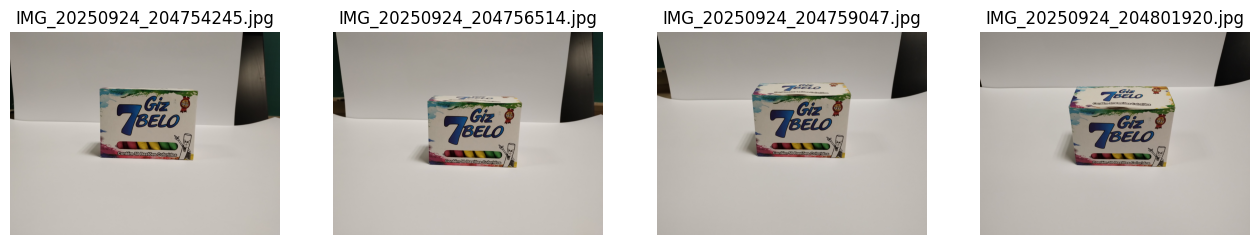

In [18]:
# Limpa execuções anteriores para garantir um começo limpo
if Path('colmap_project').exists():
    shutil.rmtree('colmap_project')

# Define os diretórios para os arquivos gerados pelo COLMAP
project_path = Path('colmap_project')
database_path = project_path / 'database.db'
output_path = project_path / 'sparse'

# Cria os diretórios para o projeto (exceto o de imagens, que será local)
project_path.mkdir(exist_ok=True)
output_path.mkdir(exist_ok=True)

print(f"Diretórios do projeto para a base de dados e saídas criados em: {project_path.resolve()}")

# Define o caminho para a pasta de imagens local
image_path = Path('imagens-t2/Imagens4')

# Verifica se a pasta existe e não está vazia
if not image_path.exists() or not any(image_path.iterdir()):
    print("="*80)
    print(f"ERRO: A pasta '{image_path}' não foi encontrada ou está vazia.")
    print("Por favor, crie esta pasta no mesmo diretório do notebook e adicione suas imagens.")
    print("="*80)
    # Lança um erro para parar a execução do notebook
    raise FileNotFoundError(f"A pasta de imagens '{image_path}' está faltando ou vazia.")
else:
    print(f"Usando imagens da pasta local: '{image_path.resolve()}'")

# Vamos visualizar algumas das imagens para confirmar
image_files = sorted(list(image_path.glob('*.[jJ][pP][gG]')) + list(image_path.glob('*.[pP][nN][gG]')))
print(f"Encontradas {len(image_files)} imagens.")

fig, axes = plt.subplots(1, min(4, len(image_files)), figsize=(16, 4))
if len(image_files) > 1:
    for i, img_file in enumerate(image_files[:4]):
        img = Image.open(img_file)
        axes[i].imshow(img)
        axes[i].set_title(img_file.name)
        axes[i].axis('off')
elif len(image_files) == 1:
    img = Image.open(image_files[0])
    axes.imshow(img)
    axes.set_title(image_files[0].name)
    axes.axis('off')
    
plt.show()

### Passo 2: Extração de Features (Keypoints)

Neste passo, o COLMAP analisará cada imagem para encontrar pontos de interesse distintos (features). Pelo que foi pesquisado, o algoritmo usado é o SIFT.

Atenção: Se você tiver uma GPU NVIDIA com CUDA configurado, pode definir use_gpu=True para uma aceleração massiva.

In [19]:
# Configurações para a extração de features
feature_options = pycolmap.SiftExtractionOptions()
feature_options.use_gpu = True # Mude para True se tiver uma GPU compatível

# Executa a extração
pycolmap.extract_features(database_path, image_path, sift_options=feature_options)

print("Extração de features concluída.")

W20250928 20:35:03.426201 140217776337984 feature_extraction.cc:404] Your current options use the maximum number of threads on the machine to extract features. Extracting SIFT features on the CPU can consume a lot of RAM per thread for large images. Consider reducing the maximum image size and/or the first octave or manually limit the number of extraction threads. Ignore this warning, if your machine has sufficient memory for the current settings.
I20250928 20:35:03.426797 140205123335744 misc.cc:44] 
Feature extraction
I20250928 20:35:03.428481 140204464059968 sift.cc:727] Creating SIFT CPU feature extractor
I20250928 20:35:03.428492 140204472452672 sift.cc:727] Creating SIFT CPU feature extractor
I20250928 20:35:03.428544 140204447274560 sift.cc:727] Creating SIFT CPU feature extractor
I20250928 20:35:03.428580 140204455667264 sift.cc:727] Creating SIFT CPU feature extractor
I20250928 20:35:03.428605 140204438881856 sift.cc:727] Creating SIFT CPU feature extractor
I20250928 20:35:03.

Extração de features concluída.


### Passo 3: Correspondência de Features (Matching)

Agora, o COLMAP irá comparar as features extraídas entre todas as imagens para encontrar correspondências (matches). Pelo que foi pesquisado, o algoritmo utilizado é: Nearest Neighbor + Verificação Geométrica com RANSAC.

In [20]:
# Configurações para a correspondência
matcher_options = pycolmap.SiftMatchingOptions()
matcher_options.use_gpu = True # Mude para True se tiver uma GPU compatível

# Executa a correspondência
pycolmap.match_exhaustive(database_path, sift_options=matcher_options)

print("Correspondência de features concluída.")

I20250928 20:36:22.625818 140205123335744 misc.cc:44] 
Feature matching
I20250928 20:36:22.648662 140204065072704 sift.cc:1434] Creating SIFT CPU feature matcher
I20250928 20:36:22.649799 140204073465408 sift.cc:1434] Creating SIFT CPU feature matcher
I20250928 20:36:22.650700 140204081858112 sift.cc:1434] Creating SIFT CPU feature matcher
I20250928 20:36:22.651724 140205114943040 sift.cc:1434] Creating SIFT CPU feature matcher
I20250928 20:36:22.652733 140205106550336 sift.cc:1434] Creating SIFT CPU feature matcher
I20250928 20:36:22.653819 140205098157632 sift.cc:1434] Creating SIFT CPU feature matcher
I20250928 20:36:22.654770 140204929046080 sift.cc:1434] Creating SIFT CPU feature matcher
I20250928 20:36:22.655809 140204937438784 sift.cc:1434] Creating SIFT CPU feature matcher
I20250928 20:36:22.656830 140204920653376 sift.cc:1434] Creating SIFT CPU feature matcher
I20250928 20:36:22.657936 140204912260672 sift.cc:1434] Creating SIFT CPU feature matcher
I20250928 20:36:22.658883 14

Correspondência de features concluída.


I20250928 20:37:44.868425 140205123335744 feature_matching.cc:47] in 16.724s
I20250928 20:37:44.868515 140205123335744 timer.cc:91] Elapsed time: 1.371 [minutes]


### Passo 4: Reconstrução Esparsa (Structure from Motion)

Este é o passo principal. Usando as correspondências de features, o pycolmap executará o mapeamento incremental (SfM) para estimar simultaneamente:

- A estrutura 3D da cena (na forma de uma nuvem de pontos esparsa).

- Os parâmetros intrínsecos e extrínsecos da câmera para cada imagem (ou seja, onde cada foto foi tirada).

In [21]:
# Executa o mapeamento incremental (reconstrução esparsa)
reconstructions = pycolmap.incremental_mapping(database_path, image_path, output_path)

print("Reconstrução esparsa concluída.")

# Imprime um resumo do maior modelo reconstruído
if reconstructions and 0 in reconstructions:
    print("\nResumo da Reconstrução:")
    print(reconstructions[0].summary())
else:
    print("\nA reconstrução falhou. Verifique se as imagens têm sobreposição suficiente e boa qualidade.")

I20250928 20:37:44.972383 140217776337984 incremental_pipeline.cc:254] Loading database
I20250928 20:37:45.015400 140217776337984 database_cache.cc:66] Loading rigs...
I20250928 20:37:45.016759 140217776337984 database_cache.cc:76]  1 in 0.001s
I20250928 20:37:45.016794 140217776337984 database_cache.cc:84] Loading cameras...
I20250928 20:37:45.017878 140217776337984 database_cache.cc:102]  1 in 0.001s
I20250928 20:37:45.017903 140217776337984 database_cache.cc:110] Loading frames...
I20250928 20:37:45.019257 140217776337984 database_cache.cc:127]  92 in 0.001s
I20250928 20:37:45.019281 140217776337984 database_cache.cc:135] Loading matches...
I20250928 20:37:45.621760 140217776337984 database_cache.cc:140]  4037 in 0.603s
I20250928 20:37:45.621813 140217776337984 database_cache.cc:156] Loading images...
I20250928 20:37:46.247609 140217776337984 database_cache.cc:241]  92 in 0.626s (connected 92)
I20250928 20:37:46.247667 140217776337984 database_cache.cc:252] Building correspondence g

Reconstrução esparsa concluída.

Resumo da Reconstrução:
Reconstruction:
	num_rigs = 1
	num_cameras = 1
	num_frames = 92
	num_reg_frames = 92
	num_images = 92
	num_points3D = 34347
	num_observations = 209810
	mean_track_length = 6.10854
	mean_observations_per_image = 2280.54
	mean_reprojection_error = 0.862968


### Passo 5.1 : Visualização da Orientação da Câmera 

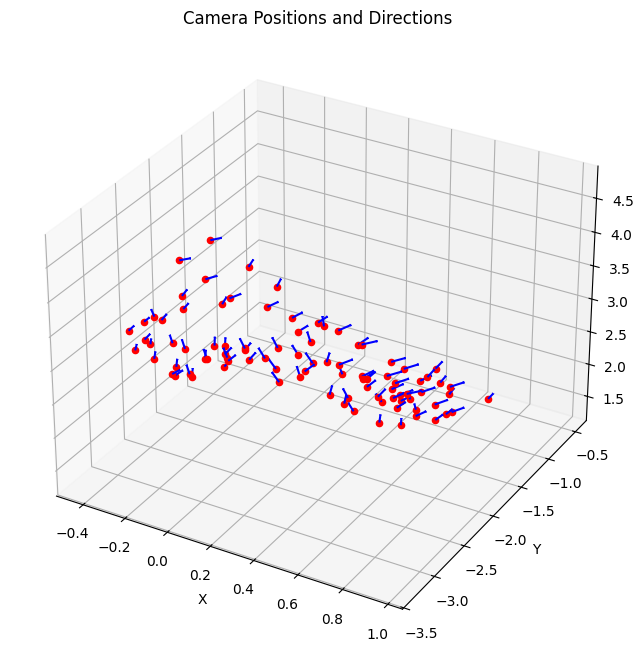

In [12]:
import numpy as np

project_path = Path('colmap_project')
database_path = project_path / 'database.db'
output_path = project_path / 'sparse/0'
image_path = Path('imagens-t2/Imagens4')

reconstruction = pycolmap.Reconstruction(output_path) 

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for image_id, image in reconstruction.images.items():
    #Posição da câmera
    cam_fromworld = image.cam_from_world()
    camera_pos = cam_fromworld.translation
    ax.scatter(camera_pos[0], camera_pos[1], camera_pos[2], c='red', marker='o')

    # Calcula a orientação da câmera
    rotation_matrix = cam_fromworld.rotation.matrix()
    forward_dir = rotation_matrix @ np.array([0, 0, 1])  # Vetor forward da câmera
    ax.quiver(
        camera_pos[0], camera_pos[1], camera_pos[2],
        forward_dir[0], forward_dir[1], forward_dir[2],
        length=0.1, color='blue', arrow_length_ratio=0.1
    )

# Axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Camera Positions and Directions')
plt.show()

### Passo 5.2: Visualização dos Resultados

Vamos carregar o modelo esparso que acabamos de criar e visualizá-lo. Inicialmente, a visualização é feita de forma estática com matplotlib. Em seguida, você poderá usar o mouse para rotacionar, dar zoom e mover a cena 3D a partir do plot com plotly. Os cones em vermelho representam as câmeras.

In [13]:
reconstruction = pycolmap.Reconstruction(output_path)
points_3d = []
for point3D_id, point3D in reconstruction.points3D.items():
    points_3d.append(point3D.xyz)  # [x, y, z] 

points_3d = np.array(points_3d)  
print(f"Números de pontos 3D: {len(points_3d)}")
print(f"Coordenadas do primeiro ponto: {points_3d[0]}")

Números de pontos 3D: 34347
Coordenadas do primeiro ponto: [0.30461158 2.52541063 2.39029289]


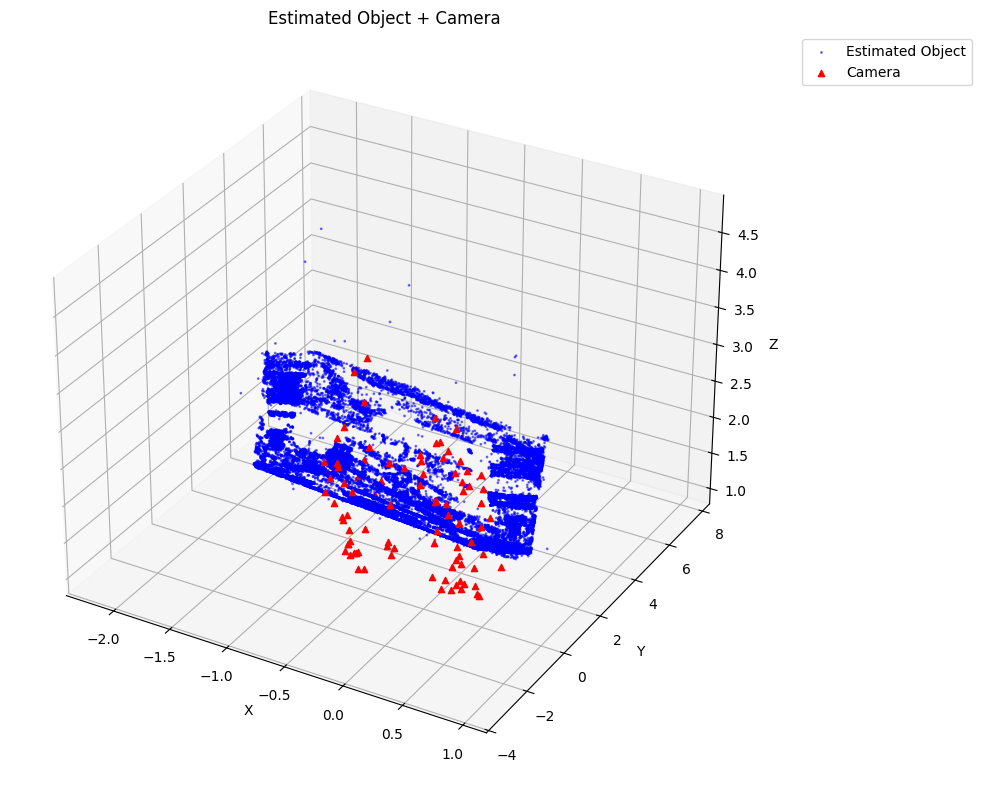

In [14]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    points_3d[:,0],  # X
    points_3d[:,1],  # Y
    points_3d[:,2],  # Z
    s=1,  
    c='blue',  
    alpha=0.5,  
    label="Estimated Object"
)

camera_plotted = False
for image in reconstruction.images.values():
    cam_fromworld=image.cam_from_world()
    cam_pos=cam_fromworld.translation
    if not camera_plotted:
        ax.scatter(cam_pos[0], cam_pos[1], cam_pos[2], c='red', marker='^', label="Camera")
        camera_plotted = True
    else:
        ax.scatter(cam_pos[0], cam_pos[1], cam_pos[2], c='red', marker='^')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Estimated Object + Camera")
plt.tight_layout()  
plt.show()

No plot 3D, a ponta do cone representa a localização da lente da câmera.

In [25]:
import plotly.graph_objects as go

# Coordenadas das câmeras
cam_x_coords, cam_y_coords, cam_z_coords = [], [], []

for image in reconstruction.images.values():
    cam_fromworld = image.cam_from_world()
    cam_pos = cam_fromworld.translation

    cam_x_coords.append(cam_pos[0])
    cam_y_coords.append(cam_pos[1])
    cam_z_coords.append(cam_pos[2])

fig = go.Figure()
fig.add_trace(
    go.Scatter3d(
        x=points_3d[:, 0],
        y=points_3d[:, 1],
        z=points_3d[:, 2],
        mode='markers',
        marker=dict(size=1.5, color='blue', opacity=0.6),
        name='Estimated Object'))

# Adiciona as cameras

fig.add_trace(
    go.Cone(
        x=cam_x_coords, y=cam_y_coords, z=cam_z_coords,
        u=-np.array(cam_x_coords), v=-np.array(cam_y_coords), w=-np.array(cam_z_coords),
        sizemode="absolute", sizeref=20, anchor="tip",
        colorscale='Reds', showscale=False, name='Camera',
        showlegend=True))

fig.update_layout(
    title_text="Visualização da Nuvem Esparsa 3D",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=True,
    legend=dict(
        x=0.8,
        y=0.9,
        xanchor='center',
        yanchor='top',
        bgcolor='rgba(255, 255, 255, 0.7)',
        bordercolor='rgba(0, 0, 0, 0.5)',
        borderwidth=1
    )
)

fig.show()

### (Opcional) Passo 6: Reconstrução Densa (Multi-View Stereo)

O resultado acima é uma "nuvem de pontos esparsa". Para obter um modelo 3D mais detalhado, podemos realizar a reconstrução densa. Isso gera um mapa de profundidade para cada imagem e depois os funde em uma nuvem de pontos densa.

**AVISO: Este processo é computacionalmente muito mais intensivo.**

In [26]:
# Verifica se a reconstrução esparsa existe antes de prosseguir
if 'reconstruction' in locals() and reconstruction and not reconstruction.is_empty():
    # Define o diretório para a reconstrução densa
    dense_path = project_path / 'dense'
    dense_path.mkdir(exist_ok=True)

    # 1. Desdistorcer as imagens
    pycolmap.undistort_images(dense_path, output_path, image_path)

    # 2. Executar o patch_match_stereo para criar mapas de profundidade
    pycolmap.patch_match_stereo(dense_path)

    # 3. Fundir os mapas de profundidade em uma nuvem de pontos densa
    pycolmap.stereo_fusion(dense_path / 'fused.ply', dense_path)

    print("\nReconstrução densa concluída!")
    print(f"O modelo 3D denso foi salvo em: {dense_path / 'fused.ply'}")
    print("Você pode abrir este arquivo .ply com um visualizador 3D como o MeshLab.")
else:
    print("\nPulando a reconstrução densa porque o modelo esparso não foi gerado com sucesso.")

AttributeError: 'pycolmap._core.Reconstruction' object has no attribute 'is_empty'

In [27]:
if 'reconstruction' in locals() and reconstruction and reconstruction.num_reg_images() > 0:
    print(f"Reconstrução válida encontrada com {reconstruction.num_reg_images()} imagens registradas e {reconstruction.num_points3D()} pontos 3D.")
    
    # Define o diretório para a reconstrução densa
    dense_path = project_path / 'dense'
    dense_path.mkdir(exist_ok=True)

    print(f"Diretório para reconstrução densa será: {dense_path}")
    
    # 1. Desdistorcer as imagens
    pycolmap.undistort_images(dense_path, output_path, image_path)

    # 2. Executar o patch_match_stereo para criar mapas de profundidade
    pycolmap.patch_match_stereo(dense_path)

    # 3. Fundir os mapas de profundidade em uma nuvem de pontos densa
    pycolmap.stereo_fusion(dense_path / 'fused.ply', dense_path)

    print("\nReconstrução densa concluída!")
    print(f"O modelo 3D denso foi salvo em: {dense_path / 'fused.ply'}")
    print("Você pode abrir este arquivo .ply com um visualizador 3D como o MeshLab.")
else:
    print("\nPulando a reconstrução densa porque o modelo esparso não foi gerado com sucesso.")

Reconstrução válida encontrada com 92 imagens registradas e 34347 pontos 3D.
Diretório para reconstrução densa será: colmap_project\dense


RuntimeError: [mvs.cc:40] PatchMatch requires CUDA but COLMAP was not compiled with it.